# 2-4_ResNet

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [ ]:
%matplotlib inline

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import warnings
warnings.filterwarnings('ignore')

# 1. Basic ResNet block

Follow the below diagram and implement the `forward()` method of the class `block`.

The computation graph should be constructed as `((conv->bn->relu->conv->bn)+shortcut)->relu`

![a](https://miro.medium.com/v2/resize:fit:1352/format:webp/1*pweIGBWkelvQw7xbfBf_Ug.png)

In [ ]:
class block(nn.Module):
    def __init__(self, filters, subsample=False):
        super().__init__()
        """
        A 2-layer residual learning building block as illustrated by Fig.2
        in "Deep Residual Learning for Image Recognition"

        Parameters:

        - filters:   int
                     the number of filters for all layers in this block

        - subsample: boolean
                     whether to subsample the input feature maps with stride 2
                     and doubling in number of filters

        Attributes:

        - shortcuts: boolean
                     When false the residual shortcut is removed
                     resulting in a 'plain' convolutional block.
        """
        # Determine subsampling
        s = 0.5 if subsample else 1.0

        # Setup layers
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3,
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()

        # Shortcut downsampling
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def shortcut(self, z, x):
        """
        Implements parameter free shortcut connection by identity mapping.
        If dimensions of input x are greater than activations then this
        is rectified by downsampling and then zero padding dimension 1
        as described by option A in paper.

        Parameters:
        - x: tensor
             the input to the block
        - z: tensor
             activations of block prior to final non-linearity
        """
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x

    def forward(self, x, shortcuts=False):
        # TODO
        # ((conv->bn->relu->conv->bn)+shortcut)->relu


        if shortcuts:
          z = self.shortcut(y, x)
        else:
          z = y

        z = self.relu2(z)

        return z

# 2. ResNet Architecture

In [ ]:
class ResNet(nn.Module):
    def __init__(self, n, shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts

        # Input (3, H, W) -> (16, H, W)
        self.convIn = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnIn   = nn.BatchNorm2d(16, track_running_stats=True)
        self.relu   = nn.ReLU()

        # Stack1 - (16, H, W) -> (16, H, W)  * n
        # TODO
        # 16개의 필터를 사용하여 residual block을 생성하고 n만큼 동일한 블록을 반복 적용
        self.stack1 =

        # Stack2 - (16, H, W) -> (32, H / 2, W / 2)  * n
        # TODO
        self.stack2 =

        # Stack3 - (32, H / 2, W / 2) -> (64, H / 4, W / 4)  * n
        # TODO
        self.stack3 =

        # Output
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fcOut   = nn.Linear(64, 10, bias=True)
        self.softmax = nn.LogSoftmax(dim=-1)

        # Initialize weights in fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()


    def forward(self, x):
        z = self.convIn(x)
        z = self.bnIn(z)
        z = self.relu(z)

        # TODO
        # 각 스택을 순회하면서 ResNet 블록을 순차적으로 적용
        for stack in [self.stack1, self.stack2, self.stack3]:


        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        return self.softmax(z)

# 3. Evaluation Function

In [ ]:
import pandas as pd
import torch

def evaluate(model, data_loader, device):
    """
    Calculate classification error (%) for given model
    and data set.

    Parameters:

    - model: A Trained Pytorch Model
    - data_loader: A Pytorch data loader object
    """

    y_true = np.array([], dtype=int)
    y_pred = np.array([], dtype=int)

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))

    error = np.sum(y_pred != y_true) / len(y_true)
    return error

# 4. Training Loop

In [ ]:
def train(model, epochs, train_loader, test_loader, criterion,
          optimizer, RESULTS_PATH, scheduler=None, MODEL_PATH=None):
    # Run on GPU if available
    device = torch.device("cuda")
    print(device)
    model.to(device)

    # Training loop
    # -------------------------------
    cols       = ['epoch', 'train_loss', 'train_err', 'test_err']
    results_df = pd.DataFrame(columns=cols).set_index('epoch')
    print('Epoch \tBatch \tNLLLoss_Train')

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        running_loss  = 0.0
        best_test_err = 1.0
        for i, data in enumerate(train_loader, 0):   # Do a batch iteration

            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print average loss for last 50 mini-batches
            running_loss += loss.item()
            if i % 50 == 49:
                print('%d \t%d \t%.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0

        if scheduler:
            scheduler.step()

        # Record metrics
        model.eval()
        train_loss = loss.item()
        train_err = evaluate(model, train_loader, device)
        test_err = evaluate(model, test_loader, device)
        results_df.loc[epoch] = [train_loss, train_err, test_err]
        results_df.to_csv(RESULTS_PATH)
        print(f'train_err: {train_err} test_err: {test_err}')

        # Save best model
        if MODEL_PATH and (test_err < best_test_err):
            torch.save(model.state_dict(), MODEL_PATH)
            best_test_err = test_err



    print('Finished Training')
    model.eval()
    return model

### A. Data Sanity Check

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler


def get_data_loaders(data_dir,
                     batch_size,
                     train_transform,
                     test_transform,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=False):
    # Load the datasets
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    test_dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=test_transform,
    )
    # Create loader objects
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )
    return (train_loader, test_loader)

In [ ]:
def plot_images(images, cls_true, cls_pred=None):
    # CIFAR10 labels
    label_names = [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]
    fig, axes = plt.subplots(3, 3)
    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


In [ ]:
# Load data without normalizations
train_transform = transforms.Compose([
    # 4 pixels are padded on each side,
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders('data',
                                             128,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


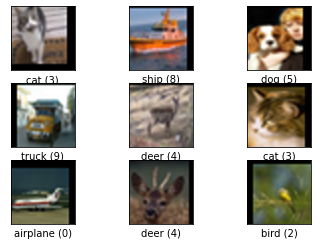

torch.Size([128, 3, 32, 32])


In [ ]:
# Training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip.

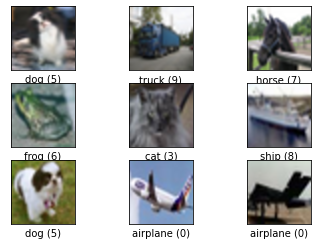

torch.Size([128, 3, 32, 32])


In [ ]:
# Test images
data_iter = iter(test_loader)
images, labels = next(data_iter)
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

### B. Calculate normalization parameters

In [ ]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalization

def calculate_normalization_params(train_loader, test_loader):
    chan0 = np.array([])
    chan1 = np.array([])
    chan2 = np.array([])

    for i, data in tqdm(enumerate(train_loader, 0)):
        images, _ = data
        chan0 = np.concatenate((chan0, images[:, 0, :, :].cpu().flatten()))
        chan1 = np.concatenate((chan0, images[:, 1, :, :].cpu().flatten()))
        chan2 = np.concatenate((chan0, images[:, 2, :, :].cpu().flatten()))

    for i, data in tqdm(enumerate(test_loader, 0)):
        images, _ = data
        chan0 = np.concatenate((chan0, images[:, 0, :, :].cpu().flatten()))
        chan1 = np.concatenate((chan0, images[:, 1, :, :].cpu().flatten()))
        chan2 = np.concatenate((chan0, images[:, 2, :, :].cpu().flatten()))

    means = [np.mean(chan0), np.mean(chan1), np.mean(chan2)]
    stds  = [np.std(chan0), np.std(chan1), np.std(chan2)]

    return means, stds


train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
means, stds = calculate_normalization_params(*get_data_loaders('data/cifar10',
                                             512,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True))
print(f'means: {means}')
print(f'stds: {stds}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


0it [00:00, ?it/s]

0it [00:00, ?it/s]

means: [0.49186879012009294, 0.4918324409801785, 0.4916811985011976]
stds: [0.24697121702736, 0.24692176198926927, 0.24703138899600283]


# 5. Construct the Data Augmentation Pipeline

Here we finalise data augmentation and normalization parameters ahead of training.

In [ ]:
# SET FINAL TRANSFORMS WITH NORMALIZATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side,
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side,
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

# 6. Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [ ]:
# TRAINING PARAMETERS
# -------------------------

data_dir = 'data/cifar10'
batch_size = 128

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 3

# OPTIMIZER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size)
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

# 7. Training the plain net

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.

In [ ]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)

    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'plainnet{6*n+2}.csv'
    model_file = f'plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion,
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.076
1 	100 	1.864
1 	150 	1.786
1 	200 	1.716
1 	250 	1.685
1 	300 	1.646
1 	350 	1.609
train_err: 0.596 test_err: 0.5896
2 	50 	1.511
2 	100 	1.480
2 	150 	1.423
2 	200 	1.380
2 	250 	1.297
2 	300 	1.275
2 	350 	1.243
train_err: 0.45938 test_err: 0.4596
3 	50 	1.173
3 	100 	1.130
3 	150 	1.088
3 	200 	1.046
3 	250 	1.054
3 	300 	1.050
3 	350 	1.025
train_err: 0.35566 test_err: 0.349
Finished Training
MODEL SIZE: n=5
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.320
1 	100 	2.175
1 	150 	2.063
1 	200 	1.971
1 	250 	1.922
1 	300 	1.847
1 	350 	1.854
train_err: 0.72186 test_err: 0.7033
2 	50 	1.771
2 	100 	1.736
2 	150 	1.701
2 	200 	1.681
2 	250 	1.670
2 	300 	1.678
2 	350 	1.616
train_err: 0.5996 test_err: 0.5852
3 	50 	1.584
3 	100 	1.560
3 	150 	1.563
3 	200 	1.560
3 	250 	1.506
3 

# 8. Training the ResNet

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [ ]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)

    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'resnet{6*n+2}.csv'
    model_file = f'resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion,
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.589
1 	100 	1.912
1 	150 	1.782
1 	200 	1.744
1 	250 	1.663
1 	300 	1.589
1 	350 	1.537
train_err: 0.56234 test_err: 0.5553
2 	50 	1.433
2 	100 	1.393
2 	150 	1.342
2 	200 	1.292
2 	250 	1.195
2 	300 	1.184
2 	350 	1.140
train_err: 0.39166 test_err: 0.3881
3 	50 	1.078
3 	100 	1.028
3 	150 	1.023
3 	200 	0.984
3 	250 	0.930
3 	300 	0.940
3 	350 	0.905
train_err: 0.38222 test_err: 0.393
Finished Training
MODEL SIZE: n=5
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	3.051
1 	100 	2.233
1 	150 	2.026
1 	200 	1.964
1 	250 	1.886
1 	300 	1.806
1 	350 	1.722
train_err: 0.62914 test_err: 0.62
2 	50 	1.641
2 	100 	1.577
2 	150 	1.527
2 	200 	1.497
2 	250 	1.427
2 	300 	1.380
2 	350 	1.336
train_err: 0.5342 test_err: 0.5277
3 	50 	1.225
3 	100 	1.233
3 	150 	1.165
3 	200 	1.153
3 	250 	1.104
3 

In [ ]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)

    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'resnet{6*n+2}.csv'
    model_file = f'resnet{6*n+2}.pt'
    train(model, 20, train_loader, test_loader, criterion,
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=None)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.168
1 	100 	1.775
1 	150 	1.669
1 	200 	1.600
1 	250 	1.528
1 	300 	1.441
1 	350 	1.391
train_err: 0.52244 test_err: 0.5063
2 	50 	1.266
2 	100 	1.216
2 	150 	1.143
2 	200 	1.116
2 	250 	1.090
2 	300 	1.052
2 	350 	0.999
train_err: 0.35508 test_err: 0.3507
3 	50 	0.957
3 	100 	0.921
3 	150 	0.909
3 	200 	0.878
3 	250 	0.861
3 	300 	0.849
3 	350 	0.818
train_err: 0.27222 test_err: 0.2859
4 	50 	0.773
4 	100 	0.770
4 	150 	0.760
4 	200 	0.764
4 	250 	0.722
4 	300 	0.730
4 	350 	0.718
train_err: 0.26574 test_err: 0.271
5 	50 	0.700
5 	100 	0.659
5 	150 	0.667
5 	200 	0.671
5 	250 	0.640
5 	300 	0.669
5 	350 	0.647
train_err: 0.27904 test_err: 0.2916
6 	50 	0.615
6 	100 	0.614
6 	150 	0.598
6 	200 	0.618
6 	250 	0.597
6 	300 	0.590
6 	350 	0.574
train_err: 0.19734 test_err: 0.2087
7 	50 	0.573
7 	100 	0.576
7 	150 	0.553
7 	200 	0.576
7 	250 	0.589
7 	300 	0

### Check model

In [ ]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

Parameter count: 853018


In [ ]:
print(model)

ResNet(
  (convIn): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bnIn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (stack1): ModuleList(
    (0): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
    )
    (1): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3

# 9. Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper.

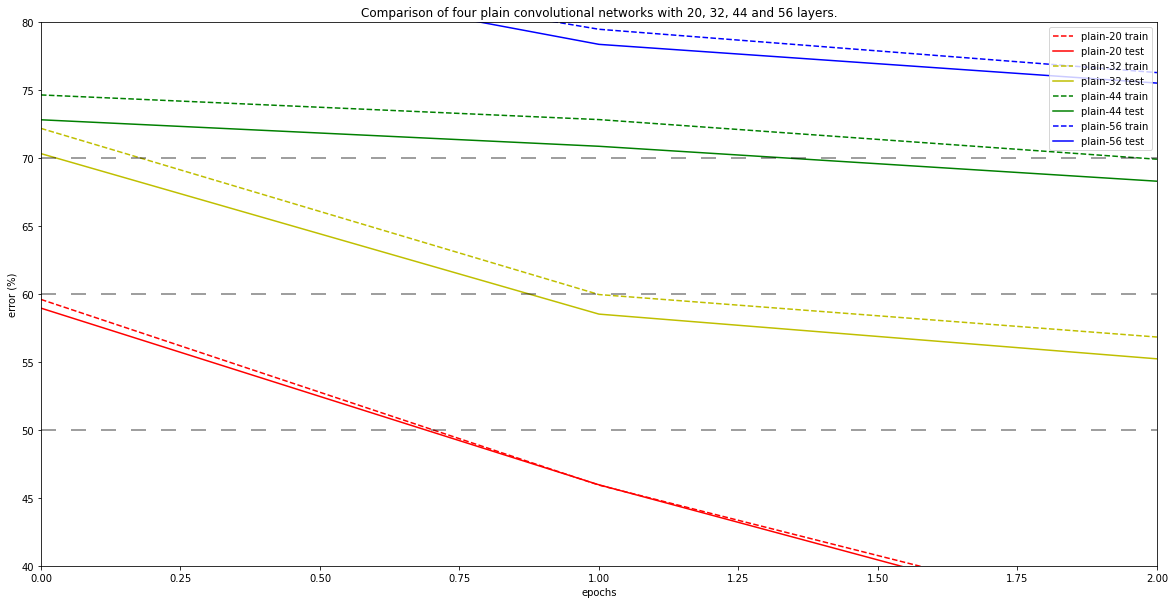

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['r', 'y', 'g', 'b']


plainnet_dfs = [pd.read_csv(f'plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 2, 40, 80])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(70, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(60, color='black', alpha=0.5, dashes=(10., 10.));
plt.axhline(50, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = [f'PlainNet{6*n+2}' for n in ns]
display(bests_df[['model', 'test_err']])

,model,test_err
2,PlainNet20,0.3490
2,PlainNet32,0.5523
2,PlainNet44,0.6830
2,PlainNet56,0.7552


### Resnet

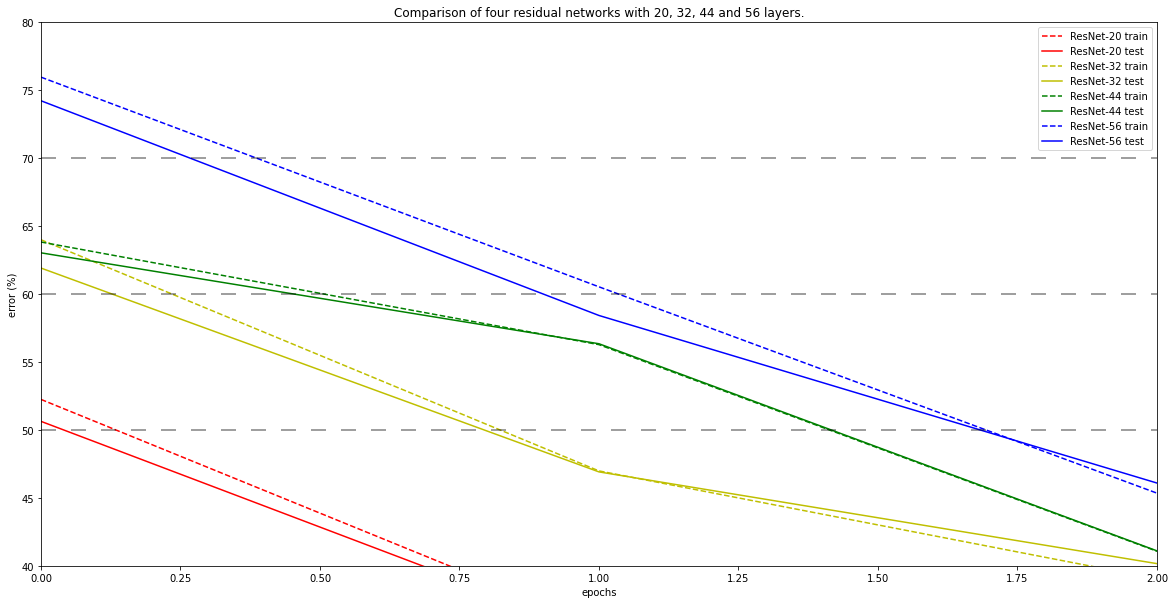

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['r', 'y', 'g', 'b']

resnet_dfs = [pd.read_csv(f'resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 2, 40, 80])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(70, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(60, color='black', alpha=0.5, dashes=(10., 10.));
plt.axhline(50, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = [f'ResNet{6*n+2}' for n in ns]
display(bests_df[['model', 'test_err']])


,model,test_err
18,ResNet20,0.1584
18,ResNet32,0.1491
19,ResNet44,0.1798
19,ResNet56,0.1530


## Side-by-side plot

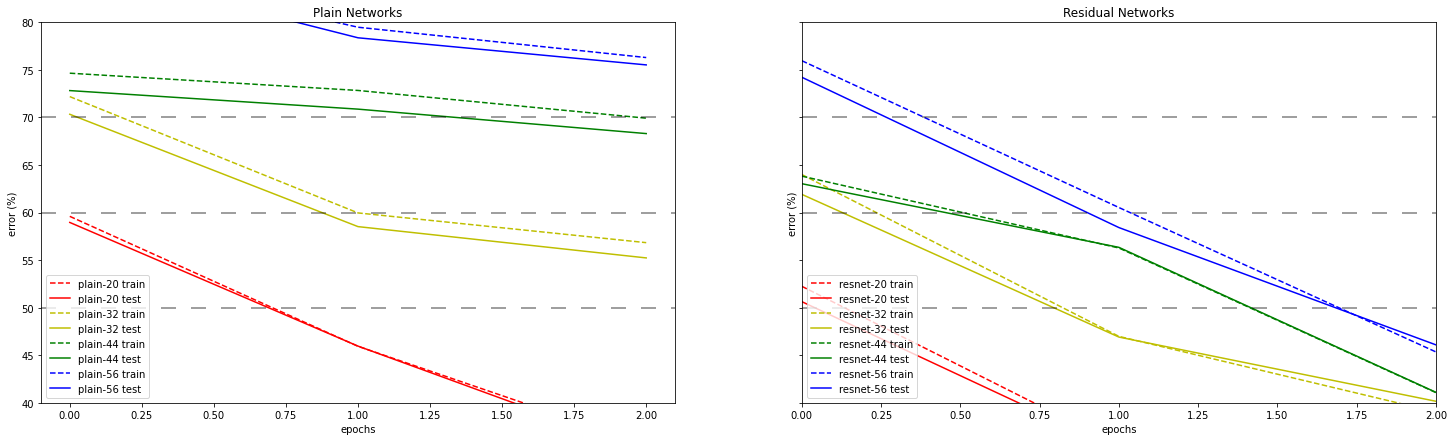

In [ ]:
ns  = [3, 5, 7, 9]
clr = ['r', 'y', 'g', 'b']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title, label, color=None):
    plt.axis([0, 2, 40, 80])

    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{color if color else clr[i]}--',
                 label=f'{label}-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{color if color else clr[i]}',
                 label=f'{label}-{6*ns[i]+2} test')

    ax.set_title(title)
    ax.legend(loc='lower left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(70, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(60, color='black', alpha=0.5, dashes=(10., 10.));
    ax.axhline(50, color='black', alpha=0.5, dashes=(10., 10.));

plot_results(plainnet_dfs, ax1, 'Plain Networks', 'plain')
plot_results(resnet_dfs, ax2, 'Residual Networks', 'resnet')

## Extra: GoogLeNet

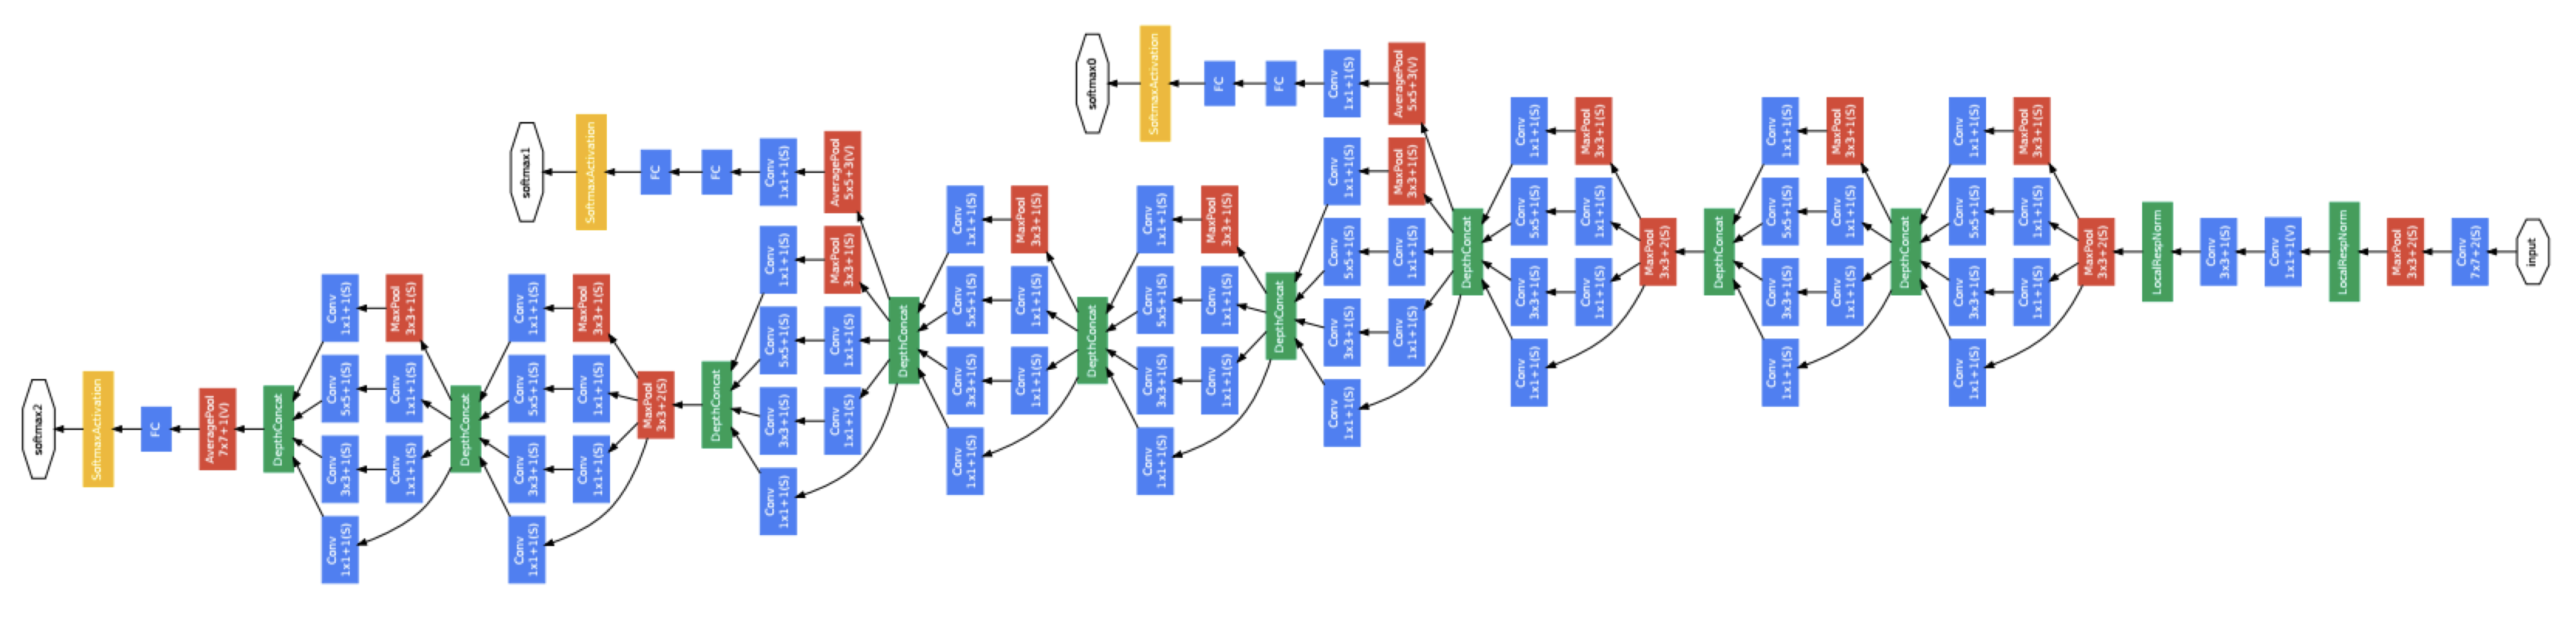

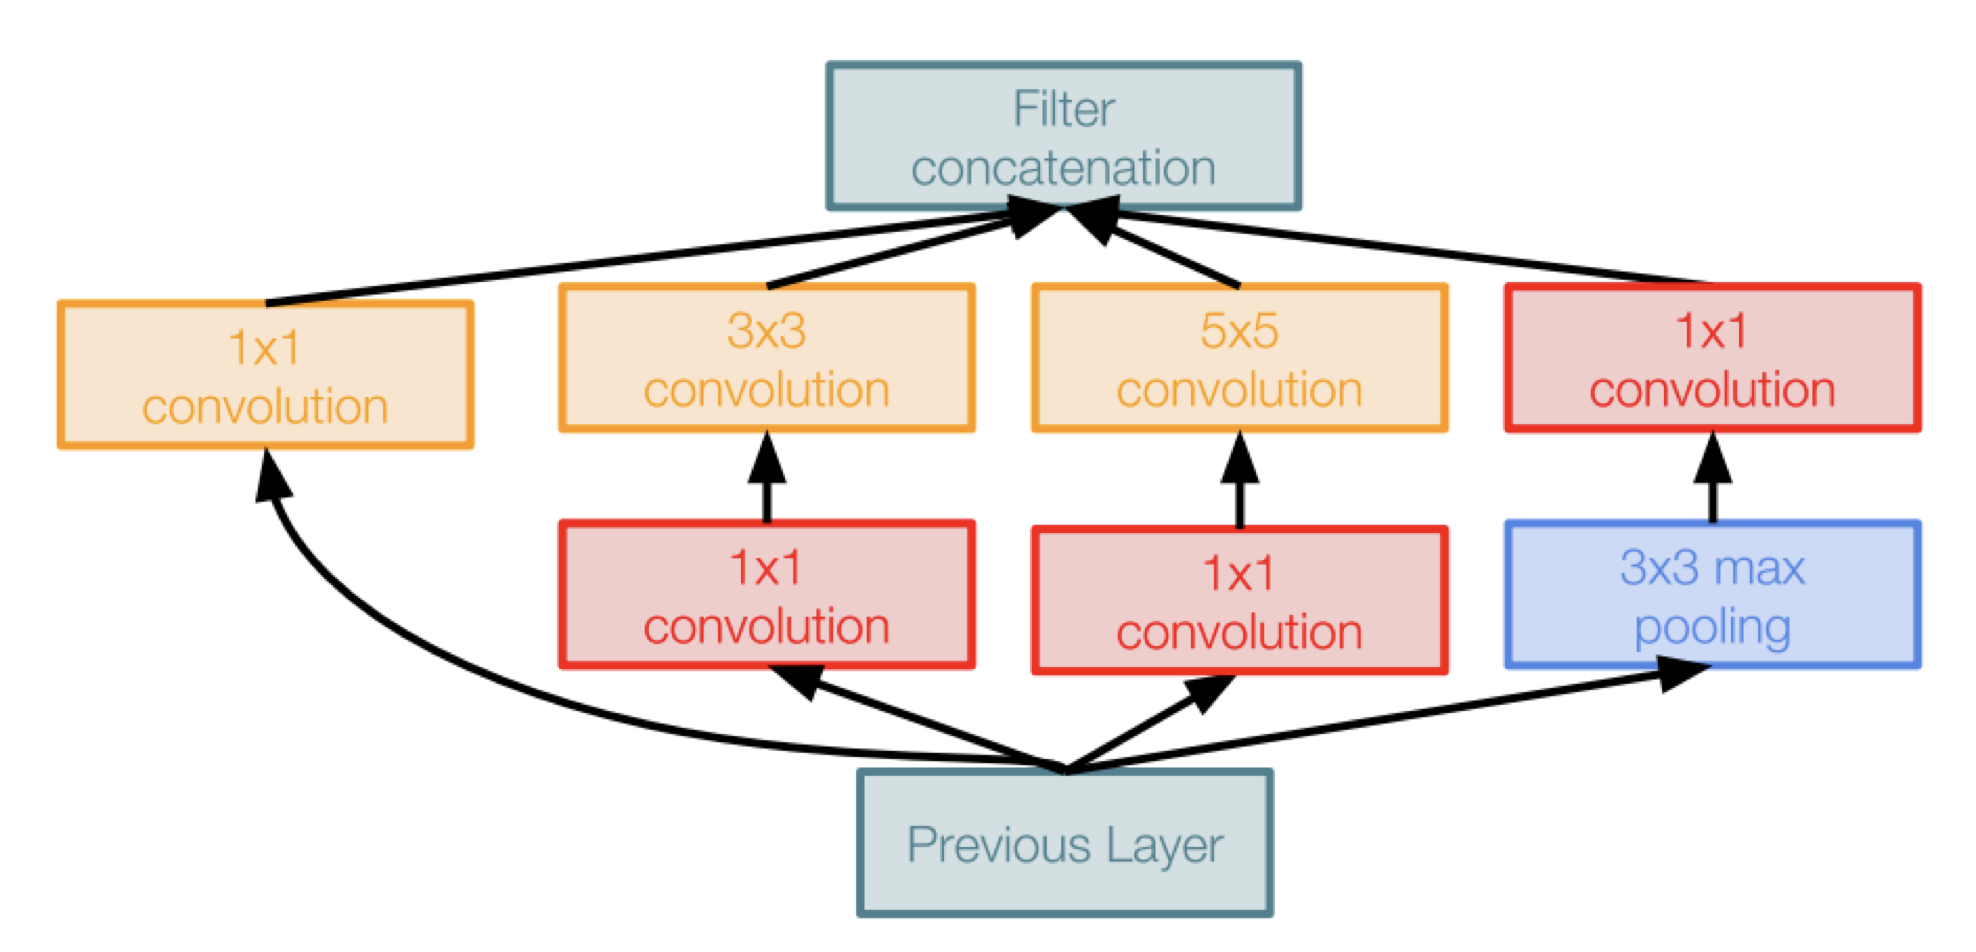

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=(kernel_size-1)//2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channels, channel1, channel2_hidden, channel2, channel3_hidden, channel3, channel4):
        super().__init__()
        self.branch1 = ConvBlock(in_channels, channel1, 1)

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, channel2_hidden, 1),
            ConvBlock(channel2_hidden, channel2, 3))

        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, channel3_hidden, 1),
            ConvBlock(channel3_hidden, channel3, 5))

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBlock(in_channels, channel4, 1))

    def forward(self, x):
        return torch.cat([branch(x) for branch in [self.branch1, self.branch2, self.branch3, self.branch4]], dim=1)

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = ConvBlock(3, 64, 7, stride=2)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, 1)
        self.conv3 = ConvBlock(64, 192, 3)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=True)
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(1024, num_classes)

    def transform_input(self, x):
        x_R = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_G = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_B = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat([x_R, x_G, x_B], 1)
        return x

    def forward(self, x):
        x = self.transform_input(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool3(x)
        x = self.a4(x)

        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)

        x = self.e4(x)
        x = self.maxpool4(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        x = self.dropout(x)

        return x

In [ ]:
class Inception_without_reduction(nn.Module):
    def __init__(self, in_channels, channel1, channel2_hidden, channel2, channel3_hidden, channel3, channel4):
        super().__init__()
        self.branch1 = ConvBlock(in_channels, channel1, 1)

        self.branch2 = ConvBlock(in_channels, channel2, 3)

        self.branch3 = ConvBlock(in_channels, channel3, 5)

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBlock(in_channels, channel4, 1))

    def forward(self, x):
        return torch.cat([branch(x) for branch in [self.branch1, self.branch2, self.branch3, self.branch4]], dim=1)

In [ ]:
class GoogLeNet_without_reduction(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = ConvBlock(3, 64, 7, stride=2)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, 1)
        self.conv3 = ConvBlock(64, 192, 3)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.a3 = Inception_without_reduction(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception_without_reduction(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=True)
        self.a4 = Inception_without_reduction(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception_without_reduction(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception_without_reduction(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception_without_reduction(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception_without_reduction(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)
        self.a5 = Inception_without_reduction(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception_without_reduction(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(1024, num_classes)

    def transform_input(self, x):
        x_R = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_G = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_B = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat([x_R, x_G, x_B], 1)
        return x

    def forward(self, x):
        x = self.transform_input(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool3(x)
        x = self.a4(x)

        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)

        x = self.e4(x)
        x = self.maxpool4(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        x = self.dropout(x)

        return x

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
print("Number of parameters of GoogLeNet: ", count_parameters(GoogLeNet()))
print("Number of parameters of GoogLeNet without reduction: ", count_parameters(GoogLeNet_without_reduction()))

Number of parameters of GoogLeNet:  7013112
Number of parameters of GoogLeNet without reduction:  25317560


## Extra: MobileNet

In [ ]:
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=(kernel_size-1)//2, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, width_multiplier=1.0, num_classes=1000):
        super().__init__()
        alpha = width_multiplier

        self.conv1 = ConvBlock(3, int(32*alpha), 3, stride=2)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), 3, stride=1)
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), 3, stride=2),
            Depthwise(int(128*alpha), int(128*alpha), 3, stride=1)
        )
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), 3, stride=2),
            Depthwise(int(256*alpha), int(256*alpha), 3, stride=1)
        )
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), 3, stride=2),
            Depthwise(int(512*alpha), int(512*alpha), 3, stride=1),
            Depthwise(int(512*alpha), int(512*alpha), 3, stride=1),
            Depthwise(int(512*alpha), int(512*alpha), 3, stride=1),
            Depthwise(int(512*alpha), int(512*alpha), 3, stride=1),
            Depthwise(int(512*alpha), int(512*alpha), 3, stride=1),
        )
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), 3, stride=2)
        )
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), 3, stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
class MobileNet_without_depthwise(nn.Module):
    def __init__(self, width_multiplier=1.0, num_classes=1000):
        super().__init__()
        alpha = width_multiplier

        self.conv1 = ConvBlock(3, int(32*alpha), 3, stride=2)
        self.conv2 = ConvBlock(int(32*alpha), int(64*alpha), 3, stride=1)
        self.conv3 = nn.Sequential(
            ConvBlock(int(64*alpha), int(128*alpha), 3, stride=2),
            ConvBlock(int(128*alpha), int(128*alpha), 3, stride=1)
        )
        self.conv4 = nn.Sequential(
            ConvBlock(int(128*alpha), int(256*alpha), 3, stride=2),
            ConvBlock(int(256*alpha), int(256*alpha), 3, stride=1)
        )
        self.conv5 = nn.Sequential(
            ConvBlock(int(256*alpha), int(512*alpha), 3, stride=2),
            ConvBlock(int(512*alpha), int(512*alpha), 3, stride=1),
            ConvBlock(int(512*alpha), int(512*alpha), 3, stride=1),
            ConvBlock(int(512*alpha), int(512*alpha), 3, stride=1),
            ConvBlock(int(512*alpha), int(512*alpha), 3, stride=1),
            ConvBlock(int(512*alpha), int(512*alpha), 3, stride=1),
        )
        self.conv6 = nn.Sequential(
            ConvBlock(int(512*alpha), int(1024*alpha), 3, stride=2)
        )
        self.conv7 = nn.Sequential(
            ConvBlock(int(1024*alpha), int(1024*alpha), 3, stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
print("Number of parameters of MobileNet: ", count_parameters(MobileNet()))
print("Number of parameters of MobileNet without depthwise: ", count_parameters(MobileNet_without_depthwise()))

Number of parameters of MobileNet:  4232008
Number of parameters of MobileNet without depthwise:  29300072
